# Exploratory Data Analysis & Modeling

###**Part 0: Set- up & Preliminary Data Checks**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.formula.api import logit
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
import copy

In [2]:
# import
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1cN2Ah5fvJoYyYHg8zVhN_JhCVOHaiRrb')
df.head()

,Lars2,Malat1,mature
0,9.95,6.69,1
1,10.54,8.53,1
2,6.58,8.74,1
3,7.49,9.09,1
4,7.42,9.87,1


###**Part A: Box plot of Expression Levels**

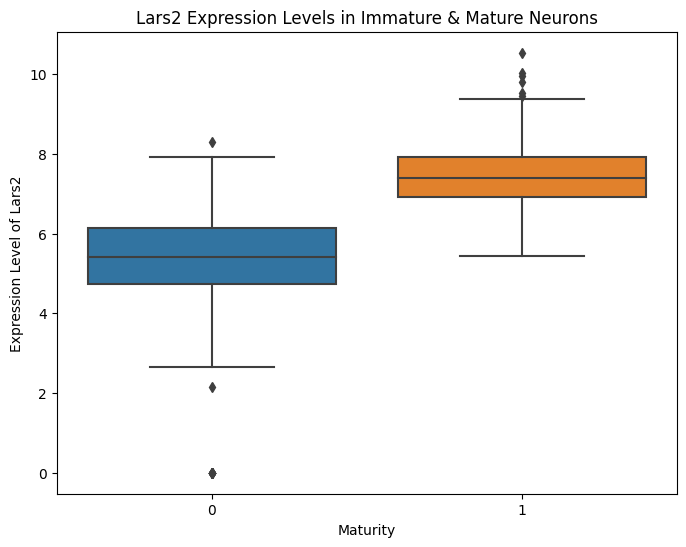

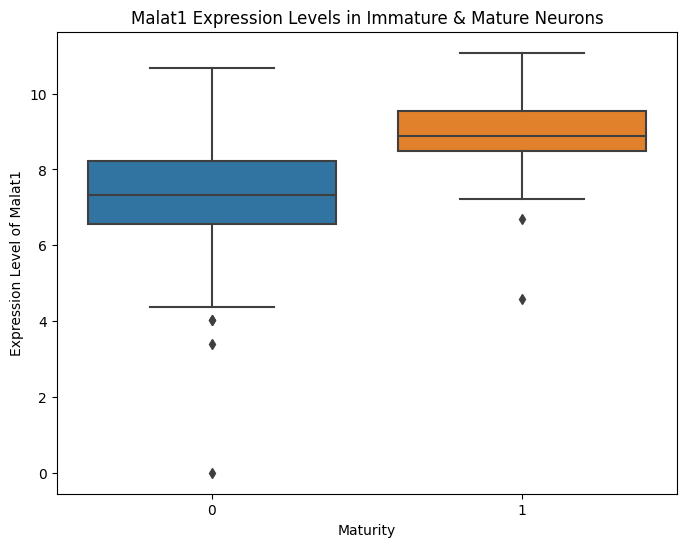

In [13]:
# Lars2
plt.figure(figsize=(8, 6))
sns.boxplot(x='mature', y='Lars2', data=df)
plt.title('Lars2 Expression Levels in Immature & Mature Neurons')
plt.xlabel('Maturity')
plt.ylabel('Expression Level of Lars2')
plt.show()

# Malat1
plt.figure(figsize=(8, 6))
sns.boxplot(x='mature', y='Malat1', data=df)
plt.title('Malat1 Expression Levels in Immature & Mature Neurons')
plt.xlabel('Maturity')
plt.ylabel('Expression Level of Malat1')
plt.show()

**Upon reviewing these plots, predicting a neuron's maturity with absolute certainty solely based on Malat1 expression is not viable. The observed data exhibits considerable variability, particularly in the overlapping expression levels observed between mature and immature neurons. This indicates that depending solely on Malat1 could lead to incorrect conclusions in several instances. Furthermore, both mature and immature cell classes exhibit outliers, further complicating the decision-making process. The same situation is observed with Lars2.**

###**Part B: Logistic Regression**

In [5]:
## Fitting a Logistic regression to predict maturity based on Malat1 expression.
mdl = logit(formula = 'mature ~ Malat1 + 1',data = df).fit()
print(mdl.summary())

Optimization terminated successfully.
         Current function value: 0.355306
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 mature   No. Observations:                  817
Model:                          Logit   Df Residuals:                      815
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                  0.2938
Time:                        01:35:46   Log-Likelihood:                -290.29
converged:                       True   LL-Null:                       -411.04
Covariance Type:            nonrobust   LLR p-value:                 1.849e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.1166      1.040    -12.614      0.000     -15.155     -11.078
Malat1         1.4254      0.

In [6]:
# The p-value for the coefficient (slope) of Malat1
mdl.pvalues['Malat1']

2.963654470477896e-32

**The p-value for the slope is extremely small, close to 0. Since this p- value is less than 0.05 we can infer that this test is statistically significant. This indicates that we can reject the null hypothesis and conclude that the expression level of Malat1 is a predictor for cell maturity.**

###**Part C: Plot of Predicted Probability**

In [22]:
# Let's now calculate the predicted probability that each neuron is mature, i.e. p = P(mature | Malat1).

# sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Example: probability that a cell with Malat1 = 10 is mature
B0 = -13.1166
B1 = 1.4254
X1 = 10
z = B0 + B1*X1
p = sigmoid(z)
print('Probability of mature given Malat1 = %2.2f is %1.4f' % (X1, p))

Probability of mature given Malat1 = 10.00 is 0.7572


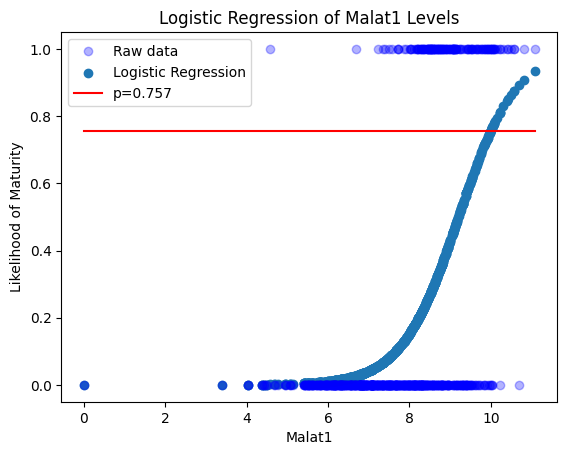

In [33]:
## Plot showing Malat1 on the x-axis vs. predicted probability on the y-axis. A sigmoid shape can be seen.
plt.plot(df['Malat1'], df['mature'], 'bo', alpha=0.3, label = 'Raw data');
plt.scatter(df.Malat1, mdl.predict(df.Malat1), label = 'Logistic Regression')
plt.plot([np.min(df['Malat1']), np.max(df['Malat1'])], [p, p],  'r', label=('p=%1.3f' % p));

plt.legend(loc='best');
plt.xlabel('Malat1');
plt.ylabel('Likelihood of Maturity');
plt.title('Logistic Regression of Malat1 Levels');
plt.show()

###**Part D: Bayesian Classification Criterion**

In [35]:
df['predict'] = mdl.predict()             # Create prediction column
df['label'] = 0                             # Initialize label (0 not mature)
df.loc[df['predict'] > 0.5, 'label'] = 1  # Label >0.5 1 (mature)

In [36]:
def sensitivity(df):
    y_true = df['mature']
    y_pred = df['label']
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    TPR = tp / (tp+fn)
    return TPR
print('Sensitivity is %f' % sensitivity(df))

Sensitivity is 0.333333


In [37]:
def specificity(df):
    y_true = df['mature']
    y_pred = df['label']
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    TNR = tn / (tn+fp)
    return TNR
print('Specificity is %f' % specificity(df))

Specificity is 0.926380


###**Part E: Predicting Maturity with a Threshold of 20%**

In [42]:
df['label'] = 0                             # Initialize label (0 not mature)
df.loc[df['predict'] > 0.2, 'label'] = 1    # Label >0.2 1 (mature)
print('Sensitivity is %f \nSpecificity is %f' % (sensitivity(df), specificity(df)))

pd.crosstab(df.mature, df.predMalat02)

Sensitivity is 0.860606 
Specificity is 0.750000


predMalat02,0,1
mature,,
0,489,163
1,23,142


**We see that as the threshold decreases, sensitivity increases, while specificity decreases. This means more cells are classified as mature due to the lower threshold. Sensitivity goes up because a wider range of values is labeled as mature. Specificity goes down because more false positives occur, incorrectly classifying more cases as mature.**

###**Part F: Plotting Lars2 vs. Malat1 expression**

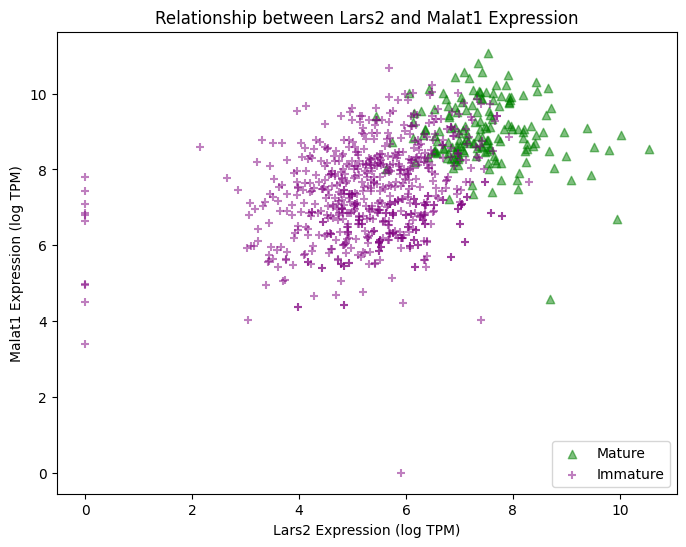

In [48]:
mature = df[df['mature'] == 1]
immature = df[df['mature'] == 0]

# Scatter plots for Lars2 vs Malat1
plt.figure(figsize=(8, 6))
plt.scatter(mature['Lars2'], mature['Malat1'], color='green', marker='^', alpha=0.5, label='Mature')
plt.scatter(immature['Lars2'], immature['Malat1'], color='purple', marker='+', alpha=0.5, label='Immature')

# label
plt.title('Relationship between Lars2 and Malat1 Expression')
plt.xlabel('Lars2 Expression (log TPM)')
plt.ylabel('Malat1 Expression (log TPM)')
plt.legend(loc='lower right')

plt.show()

###**Part G: Multinomial Logistic Regression**

In [54]:
# Fitting a logistic regression using both Lars2 and Malat1 as predictors.

mdl2 = logit(formula = "mature ~ Lars2 + Malat1 + 1", data = df).fit()
print(mdl2.summary())

Optimization terminated successfully.
         Current function value: 0.196827
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 mature   No. Observations:                  817
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            2
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                  0.6088
Time:                        02:14:47   Log-Likelihood:                -160.81
converged:                       True   LL-Null:                       -411.04
Covariance Type:            nonrobust   LLR p-value:                2.122e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.5697      2.177    -11.743      0.000     -29.838     -21.302
Lars2          2.3119      0.

In [55]:
mdl.pvalues

Intercept    1.778622e-36
Malat1       2.963654e-32
dtype: float64

**Both Lars2 expression and Malat1 expression are statistically significant predictors of cell maturity, indicated by their p-values being below the 0.05 threshold.**

###**Part H: Predicting Maturity**

In [56]:
# We will use the new model to predict whether each neuron is mature,
# using a Bayesian decision threshold: P(mature | Malat1, Lars2) > 0.5

df['predict'] = mdl2.predict()             # Create prediction column
df['label'] = 0                             # Initialize label (0 not mature)
df.loc[df['predict'] >= 0.5, 'label'] = 1 # Label >0.5 1 (mature)
print('Sensitivity is %f \nSpecificity is %f' % (sensitivity(df), specificity(df)))

Sensitivity is 0.727273 
Specificity is 0.947853


**Compared to the sensitivity and specificity calculated in the simpler model, the values signfiicatly changed with the complex model. More specifically, the sensitivity decreased, whereas the specificity increased. This implications of this would be that the model is less likely to identify true positives, but more likely to correctly identify true negatives.**